# Downloading the Dataset

In [ ]:
# !wget https://os.unil.cloud.switch.ch/fma/fma_small.zip

In [ ]:
# !7z x fma_small.zip

In [ ]:
# !rm fma_small.zip

In [ ]:
# !wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip

In [ ]:
# !7z x fma_metadata.zip

In [ ]:
# !rm fma_metadata.zip

# Preprocessing

In [ ]:
# import glob
# files = glob.glob('fma_small/**/*.mp3', recursive=True)

In [ ]:
import os
import matplotlib.pyplot as plt
import pylab
import librosa
import librosa.display
import numpy as np

# def create_mel_spec(filename):
#     sig, fs = librosa.load(filename)
#     print()
#     # make pictures name 
#     save_path = 'images_melspec/' + filename.split('/')[-1].split('.')[0].lstrip('0') + '.png'
#     pylab.axis('off')
#     pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
#     S = librosa.feature.melspectrogram(y=sig, sr=fs)
#     librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
#     pylab.savefig(save_path, bbox_inches=None, pad_inches=0)
#     pylab.close()

In [ ]:
# count = 0
# for x in files:
#     count+=1
#     print(count)
#     create_mel_spec(x)

In [ ]:
# !wget "https://raw.githubusercontent.com/imshubhamsingh/music-genre-classification-fma/master/preprocessing/train_labels.csv"

In [ ]:
# !mkdir music_plots

In [ ]:
import pandas as pd
df = pd.read_csv('train_labels.csv')
df

,track_id,genre
0,2,Hip-Hop
1,5,Hip-Hop
2,10,Pop
3,140,Folk
4,141,Folk
...,...,...
7995,154308,Hip-Hop
7996,154309,Hip-Hop
7997,154413,Pop
7998,154414,Pop


In [ ]:
import glob
g = glob.glob('images_melspec/*.png')

In [ ]:
list_filenames= [x.split('/')[-1].split('.')[0] for x in g]

In [ ]:
list_filenames = [int(x) for x in list_filenames]

In [ ]:
labels = pd.DataFrame(columns = ["track_id", "genre"])
for index, row in df.iterrows():
    if row['track_id'] in list_filenames:
        labels=labels.append({'track_id': row['track_id'], 'genre':row['genre']}, ignore_index=1)
df=labels 

# EDA

In [ ]:
num = df['genre'].value_counts()
classes = df['genre'].unique()
print("Percentage of each class")
for cl in classes:
  print(cl,'\t',num[cl]/df.shape[0]*100,"%")

Percentage of each class
Hip-Hop 	 12.504689258471927 %
Pop 	 12.504689258471927 %
Folk 	 12.504689258471927 %
Experimental 	 12.492184569213455 %
Rock 	 12.492184569213455 %
International 	 12.504689258471927 %
Electronic 	 12.492184569213455 %
Instrumental 	 12.504689258471927 %


In [ ]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df["genre_encoded"] = lb_make.fit_transform(df["genre"])
df.head()

,track_id,genre,genre_encoded
0,2,Hip-Hop,3
1,5,Hip-Hop,3
2,10,Pop,6
3,140,Folk,2
4,141,Folk,2


# Music Categorization

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import time


class song_genre(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = annotation_file
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, (str(img_id) + '.png'))).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 2]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, int(y_label))

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((246, 246)),
            transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
        ]
    )

In [ ]:
dataset = song_genre("images_melspec",df,transform=transform)

In [ ]:
train_set, validation_set, test_set = torch.utils.data.random_split(dataset,[6000,1000,997])

In [ ]:
epochs = 10
batch_size = 64
shuffle = True
pin_memory = True
num_workers = 1

In [ ]:
train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)
test_set = DataLoader(dataset=test_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
class PretrainedImagenet(nn.Module):
    def __init__(self, original_model=None):
        super(PretrainedImagenet, self).__init__()
        if original_model is None:
            original_model = vision_models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(original_model.children())[:-3])
        for i, p in enumerate(self.features.parameters()):
            p.requires_grad = False
        self.pool = nn.AvgPool2d(kernel_size=7, stride=2, padding=0)
        self.val = nn.Linear(77824, 1)
        self.en = nn.Linear(77824, 1)
        self.danc = nn.Linear(77824, 1)

    def forward(self, x):
        out = self.features(x.unsqueeze(1).repeat(1, 3, 1, 1))
        out = self.pool(out)
        out = out.view(x.size(0),  -1)
        val = torch.sigmoid(self.val(out))
        en = torch.sigmoid(self.en(out))
        danc = torch.sigmoid(self.danc(out))
        return val.view(-1), en.view(-1), danc.view(-1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
device

device(type='cuda', index=0)

In [ ]:
model = nn.DataParallel(models.resnet18(pretrained=True))
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/nivedita.rufus/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(1024, 256), nn.ReLU(), nn.Linear(256, 8))

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def train(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_set)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [ ]:
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(validation_set)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == target).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
        
        return loss, accuracy

In [ ]:
def test(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, target = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct, total

In [ ]:
def save_checkpoint(state):
    torch.save(state, 'model.pth')

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
acc_max = 0
print(f"Training on train examples, validating on validation examples...")
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = train(model, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(model, validation_loader)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)

    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    if(acc_max<val_epoch_accuracy):
      print("Validation accuracy increased, saving the model")
      save_checkpoint({'model': model.state_dict()})
      acc_max = val_epoch_accuracy

end = time.time()
print((end-start)/60, 'minutes')

Training on train examples, validating on validation examples...
Epoch 1 of 10
Training


94it [01:10,  1.33it/s]                        

Train Loss: 0.0445, Train Acc: 46.17
Validating



16it [00:11,  1.34it/s]                        


Val Loss: 0.0231, Val Acc: 56.50
Validation accuracy increased, saving the model
Epoch 2 of 10
Training


94it [01:06,  1.41it/s]                        

Train Loss: 0.0172, Train Acc: 64.80
Validating



16it [00:11,  1.34it/s]                        

Val Loss: 0.0213, Val Acc: 56.00
Epoch 3 of 10
Training



94it [01:06,  1.42it/s]                        

Train Loss: 0.0114, Train Acc: 75.93
Validating



16it [00:11,  1.44it/s]                        

Val Loss: 0.0234, Val Acc: 55.70
Epoch 4 of 10
Training



94it [01:06,  1.41it/s]                        

Train Loss: 0.0053, Train Acc: 90.05
Validating



16it [00:11,  1.43it/s]                        

Val Loss: 0.0272, Val Acc: 54.20
Epoch 5 of 10
Training



94it [01:06,  1.41it/s]                        

Train Loss: 0.0020, Train Acc: 96.90
Validating



16it [00:11,  1.43it/s]                        

Val Loss: 0.0286, Val Acc: 56.00
Epoch 6 of 10
Training



94it [01:06,  1.42it/s]                        

Train Loss: 0.0009, Train Acc: 99.00
Validating



16it [00:11,  1.37it/s]                        


Val Loss: 0.0297, Val Acc: 58.00
Validation accuracy increased, saving the model
Epoch 7 of 10
Training


94it [01:06,  1.42it/s]                        

Train Loss: 0.0006, Train Acc: 99.23
Validating



16it [00:11,  1.42it/s]                        


Val Loss: 0.0311, Val Acc: 58.60
Validation accuracy increased, saving the model
Epoch 8 of 10
Training


94it [01:07,  1.40it/s]                        

Train Loss: 0.0005, Train Acc: 99.40
Validating



16it [00:11,  1.43it/s]                        

Val Loss: 0.0326, Val Acc: 56.10
Epoch 9 of 10
Training



94it [01:07,  1.39it/s]                        

Train Loss: 0.0005, Train Acc: 99.33
Validating



16it [00:11,  1.40it/s]                        

Val Loss: 0.0331, Val Acc: 58.40
Epoch 10 of 10
Training



94it [01:15,  1.24it/s]                        

Train Loss: 0.0005, Train Acc: 99.38
Validating



16it [00:11,  1.40it/s]                        

Val Loss: 0.0356, Val Acc: 55.20
13.284251431624094 minutes


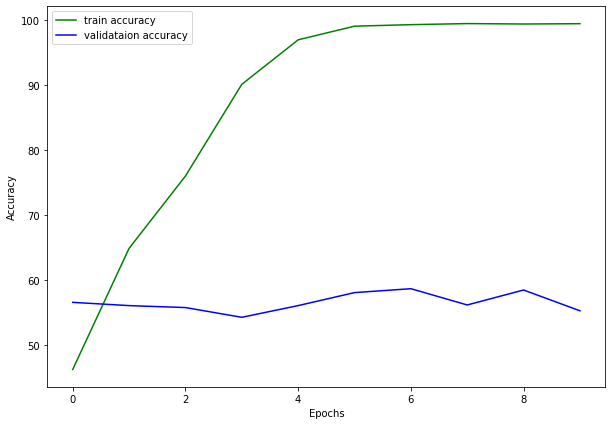

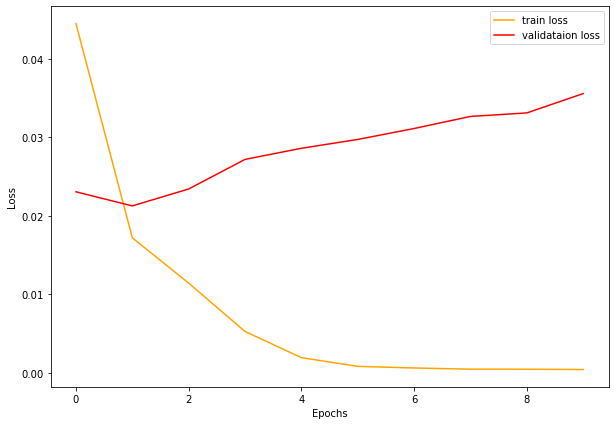

In [ ]:

# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./music_plots/accuracy.png')
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./music_plots/loss.png')

In [ ]:
best_model = torch.load("./model.pth")
print(best_model.keys())
model.load_state_dict(best_model['model'])
correct, total = test(model, test_set)
print('Accuracy of the network on test images: %0.3f %%' % (100 * correct / total))
print('finished running')

dict_keys(['model'])
Accuracy of the network on test images: 58.877 %
finished running
